<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/ML.jpg" alt="Drawing" style="width:1000px;">



# <center> 06. Classification! </center>
    
## <span style="color:red"> Outline </span>

[**1. Introduction to Classification**](#eje1)

[**2. A naive example for Naive classifiers: trilobites**](#eje2)

[**3. The Naive Gaussian Bayes: Solving a real classification problem**](#eje3)

[**4. Metrics and Evaluation on classification**](#eje4)

[**5. Other Classifiers**](#eje5)

In [1]:
#@title 1. MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Machine_Learning_Course/')
print(os.getcwd())


MessageError: Error: credential propagation was unsuccessful

In [ ]:
#@title 2. LOAD LIB { display-mode: "form" }
from __future__ import division, print_function, unicode_literals #py2 and py3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.metrics import *

## <span style="color:red"> 1. Introduction to Classification  <a name="eje1"></a> </span>

   - The classification is the problem of predicting a discrete class label output for an example.
   - The regression is the problem of predicting a continuous quantity output for an example
    
**Function Approximation:** The idea is  developing a model using historical data to make a prediction on new data where we do not have the answer. This is done by approximating a function:    

$$\hat{f}: x(t) \to y(t)$$

$x(t) = \left \{ x_1, x_2, \ldots x_n  \right \}$ is input data, while $y(t) = \left \{0,1 \right \}$ is output data. For classification, $y(t)$ are discrete output variables. For instance, an e-mail can classified as "spam" and "nor-spam"


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/PipelineImage.jpg" style="width:1000px;">


## <span style="color:red"> 2.  A naive example for Naive classifiers: trilobites <a name="eje2"></a> </span>
    
    

It is a simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features.

## - Comeback to trilobites example

- Load data and write on machine learning scheme (features and labels)


In [ ]:
tr1 = pd.read_csv("data/trilobites1.csv.gz").sample(frac=.5)
print(tr1.shape)
tr1["label"] = 0
tr2 = pd.read_csv("data/trilobites2.csv.gz")
print(tr2.shape)
tr2["label"] = 1
d = pd.concat((tr1, tr2)).sample(frac=1).reset_index(drop=True)
del(d["width"])
print(d.shape)
d.head()

(5000, 2)
(10000, 2)
(15000, 2)


,length,label
0,2.901129,0
1,5.741179,1
2,2.926837,0
3,2.725801,1
4,4.080671,0


Text(0.5, 0, 'length')

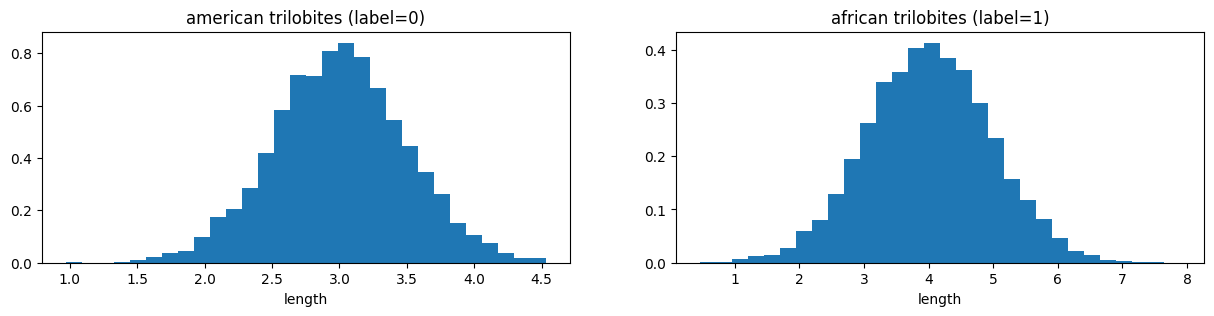

In [ ]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.hist(d[d.label==0].length.values, bins=30, density=True)
plt.title("american trilobites (label=0)")
plt.xlabel("length")
plt.subplot(122)
plt.hist(d[d.label==1].length.values, bins=30, density=True);
plt.title("african trilobites (label=1)")
plt.xlabel("length")

Given a new trilobite $x$ for which we do not know its class, Naive Bayes works as follows to estimate it:
    
- Estimate $P(0|x)$ and $P(1|x)$, the probability of the class being 0 or 1 given the piece of data that we have now ($x$)
- Choose the one with highest probability.

Stop and think from a Bayesian perspective. What information we had before seeing $x$?

Using Bayes:

$$P(0|x) = \frac{P(x|0) P(0)}{P(x)} \;\;\;\;\;\;\;\;P(1|x) = \frac{P(x|1) P(1)}{P(x)}$$

- $P(0)$ and $P(1)$ is the probability of seen an american or an african trilobite
- $P(x|0)$ is the probability of our new trilobite $x$ belonging to class 0. $P(x|1)$ likewise for class 1.
- $P(x)$ is the absolute probability of $x$.

How can we compute each term so that we can estimate $P(0|x)$ and $P(1|x)$?

- for $P(0)$ and $P(1)$ we can use the frequencies of appearance observed in our dataset
- for $P(x|0)$ (or $P(x|1)$ we do not know their distributions (their shape in the charts above). We can **assume they are Gaussian** and use the corresponding PDF to compute probabilities.
- $P(x)$ is very hard, but we do not really need it as it is a common factor of $P(0|x)$ and $P(1|x)$, $\in [0,1]$, and we are only interested in their comparison.

Now, for the Gaussian PDF of $P(x|0)$ we need two parameters: $\mu_0$ and $\sigma_0$, which we can estimate using the corresponding items from our dataset.

Let's say our new trilobite has a length of 3.5




In [ ]:
x = 3.5

estimate $P(0)$ and $P(1)$, must correspond to the observed frequencies of our classes

In [ ]:
p_0 = np.mean(d.label==0)
p_1 = np.mean(d.label==1)
print ("%.3f %.3f"%(p_0, p_1))

0.333 0.667


build the corresponding PDFs for each class using our dataset

In [ ]:
lengths0, lengths1 = d[d.label==0].length, d[d.label==1].length
pdf0 = stats.norm(loc=np.mean(lengths0), scale=np.std(lengths0)).pdf
pdf1 = stats.norm(loc=np.mean(lengths1), scale=np.std(lengths1)).pdf

estimate $P(x|0)$ and $P(x|1)$

In [ ]:
p_x_given_0 = pdf0(x)
p_x_given_1 = pdf1(x)
print ("%.3f %.3f"%(p_x_given_0, p_x_given_1))

0.486 0.362


and finally

In [ ]:
p_0_given_x = p_x_given_0 * p_0
p_1_given_x = p_x_given_1 * p_1
print ("%.3f %.3f"%(p_0_given_x, p_1_given_x))
print ("predicted class:", 0 if p_0_given_x>p_1_given_x else 1)

0.162 0.241
predicted class: 1


- **Pros:** Simple to implement and fast. Works well with a large number of features and can handle irrelevant features gracefully.
- **Cons:** Assumes independence between features, which may not hold true in many real-world scenarios

## <span style="color:red"> 3. The Naive Gaussian Bayes: Solving a real classification problem <a name="eje3"></a> </span>

- An advantage of naive Bayes is that it only requires a small number of training data to estimate the parameters necessary for classification

-  A naive Bayes classifier considers each of these features to contribute independently to the probability that this fruit is an apple, regardless of any possible correlations between the color, roundness, and diameter features.

- It is not necessary the computation of covariance matrix

### Go to real-life!: a second example


Attribute Information:

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

In [ ]:
d = pd.read_csv("data/data_banknote_authentication.txt.gz")
print(d.shape)
d.head()

(1372, 5)


,varwt,skewt,curwt,entrwt,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


first inspection of data and binary relationships.

- are variables normal?
- what relations do you see?

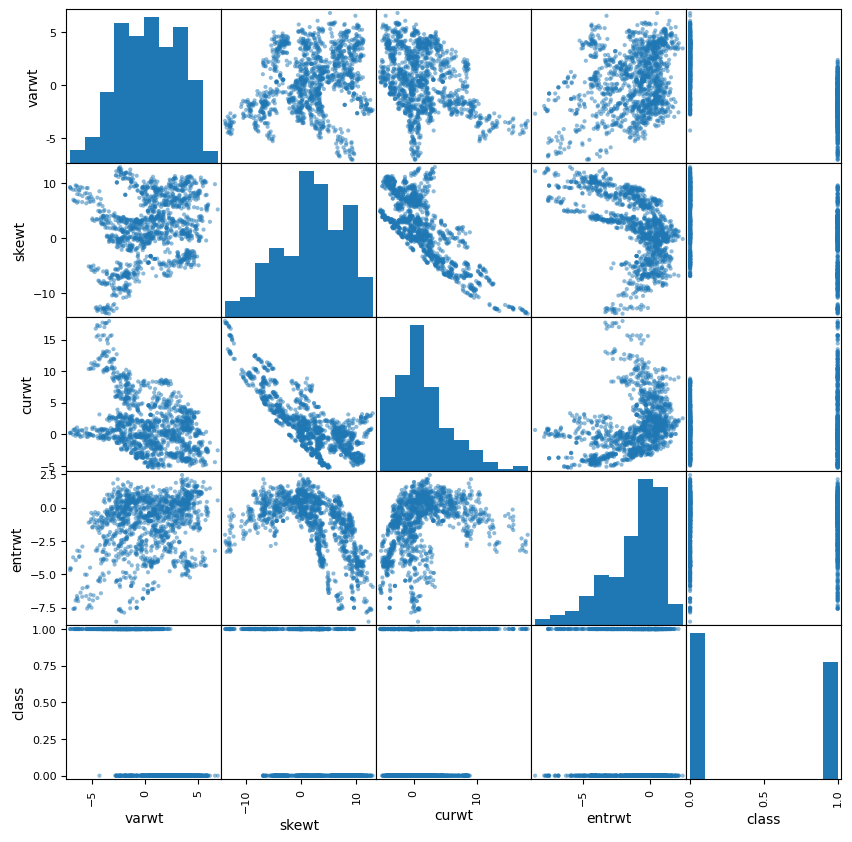

In [ ]:
pd.plotting.scatter_matrix(d, figsize=(10,10));

now split data: input columns and colum to be predicted

In [ ]:
X = d.values[:,:-1]
y = d.values[:,-1]


now create an estimator, train and predict

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
est = GaussianNB()

est.fit(X,y)
predictions = est.predict(X)
print( "first 100 predictions", predictions[:100])
print( "first 100 targets    ", y[:100])


first 100 predictions [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1.]
first 100 targets     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


accuracy of predicions

In [ ]:
print("%.3f"%accuracy_score(predictions, y))

0.841


but wait! we are cheating!! cannot use same data for training and for test. let's use the first half for training and the rest for test

In [ ]:
n = int(len(X)/2)
est.fit(X[:n], y[:n])
print("%.3f"%accuracy_score(est.predict(X[n:]), y[n:]))

0.111


what happened?!?!?

In [ ]:
print("first 100", y[:100])
print("last  100", y[-100:])
print("class distribution", [(i, sum(y==i)) for i in np.unique(y)])

first 100 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
last  100 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
class distribution [(0.0, 762), (1.0, 610)]


data is not shuffled, we are training only with one class. understand next chart and how it is built

Text(0.5, 0, 'n')

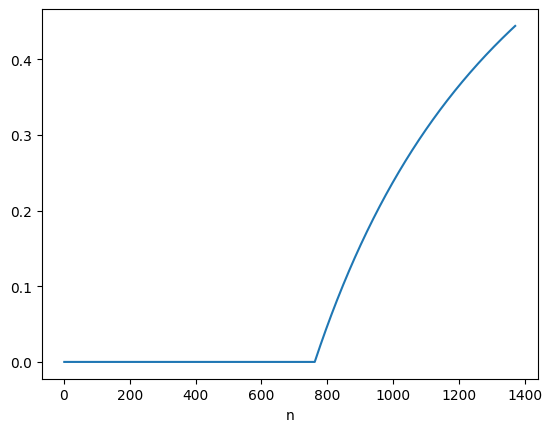

In [ ]:
t = range(1,len(y))
p = [np.mean(y[:i]) for i in t]
plt.plot(t,p)
plt.xlabel("n")

## <span style="color:red"> 4. Metrics and Evaluation on classification <a name="eje4"></a> </span>

Let's use cross validation and build more confidence in our results

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/kfold.jpg" style="width:400px;">

In [ ]:
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print (s)
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

[0.82608696 0.82608696 0.81751825 0.88321168 0.8540146  0.81751825
 0.81021898 0.79562044 0.87591241 0.88321168]
accuracy 0.839 (+/- 0.03076)


let's understand better how this estimator is performing.

- TPR: true positive rate (sensitivity), e.g.,  the percentage of sick people who are correctly identified as having the condition
- TNR: true negative rate (specificity), e.g., the percentage of healthy people who are correctly identified as not having the condition

From Wiki:

- True positive: Sick people correctly identified as sick
- False positive: Healthy people incorrectly identified as sick
- True negative: Healthy people correctly identified as healthy
- False negative: Sick people incorrectly identified as healthy

In general

- True positive = correctly identified
- False positive = incorrectly identified
- True negative = correctly rejected
- False negative = incorrectly rejected

In [ ]:
def tpr(est,X,y):
    p = est.predict(X)
    return np.mean (p[y==1] == y[y==1])

def tnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==0] == y[y==0])

In [ ]:
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print ("tpr %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print ("tnr %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

tpr 0.792 (+/- 0.03839)
tnr 0.880 (+/- 0.03989)


## <span style="color:red"> 5. Other Classifiers <a name="eje5"></a> </span>


In [ ]:
d = pd.read_csv("data/data_banknote_authentication.txt.gz")
print(d.shape)
d.head()

(1372, 5)


,varwt,skewt,curwt,entrwt,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


### Decision Tree classifier

The idea is to create a model that predicts the value of a target variable based on several input variables. The observations about an item is represented in the branches and the conclusions about the item's target value represented in the leaves


- Tree models where the target variable can take a discrete set of values are called **classification trees**
- Decision trees where the target variable can take continuous values (typically real numbers) are called **regression trees**


Now split data: input columns and colum to be predicted

In [ ]:
X = d.values[:,:-1]
y = d.values[:,-1]

let's understand better how this estimator is performing.

- TPR: true positive rate (sensitivity), e.g.,  the percentage of sick people who are correctly identified as having the condition
- TNR: true negative rate (specificity), e.g., the percentage of healthy people who are correctly identified as not having the condition

From Wiki:

- True positive: Sick people correctly identified as sick
- False positive: Healthy people incorrectly identified as sick
- True negative: Healthy people correctly identified as healthy
- False negative: Sick people incorrectly identified as healthy

In general

- True positive = correctly identified
- False positive = incorrectly identified
- True negative = correctly rejected
- False negative = incorrectly rejected

In [ ]:
def tpr(est,X,y):
    p = est.predict(X)
    return np.mean (p[y==1] == y[y==1])

def tnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==0] == y[y==0])

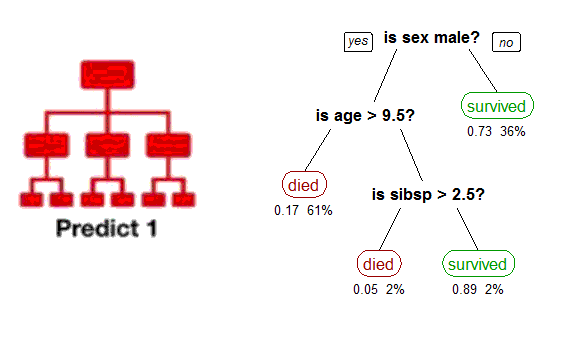

In [ ]:
from IPython.display import Image
Image(filename='imgs/CART_tree_titanic_survivors.png')

we now use other estimators. Observe the all follow sklearn API

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

est = DecisionTreeClassifier()

s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print("tpr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print("tnr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.985 (+/- 0.00976)
tpr      0.990 (+/- 0.01074)
tnr      0.985 (+/- 0.01308)


**Many times is useful to know what features are more important to classify!**

In [ ]:
est.fit(X,y)
est.feature_importances_

array([0.58162542, 0.24128651, 0.15591827, 0.02116979])

- **Pros:** Easy to understand and interpret. Can handle both numerical and categorical data. Trees can be visualized, which helps in understanding the model's decision-making process.
- **Cons:** Prone to overfitting, especially with complex trees. Might not achieve as high accuracy as more sophisticated models.

## <span style="color:orange">student</span>:
Perform a classification using the most detected important features. Which classifier is best?

### Random Forest classifier (RFC)

Many times the tree is dependent of features initialization and the output can be sensible. To overcome some of these problems, a set of trees can be built to perform the classification. Each tree give a result an agreement criteria is used to obtain the classification

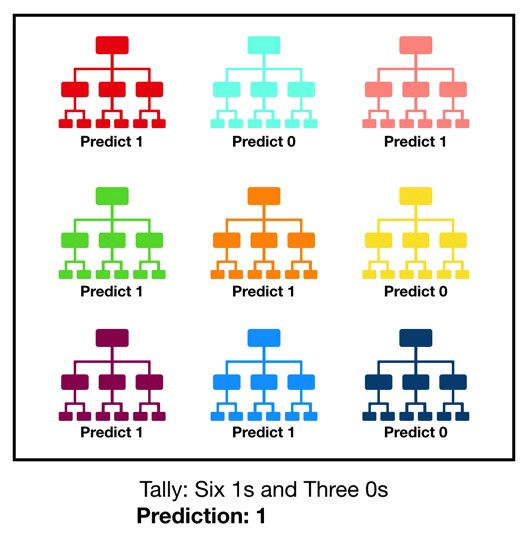

In [ ]:
from IPython.display import Image
Image(filename='imgs/randomforest.jpeg', width=500)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

est = RandomForestClassifier()

s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print("tpr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print("tnr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.995 (+/- 0.00732)
tpr      0.995 (+/- 0.01044)


- **Pros:** Usually provides a higher level of accuracy than a single decision tree. Handles overfitting better than decision trees and is good with datasets that have many features and complex relationships.
- **Cons:** Less interpretable than a single decision tree due to its ensemble nature. Computationally more intensive.

### Support vector machine (SVM)

This strategy is one of the most know machine learning thecnique. It is based on learn a model to separate two classes, which are represented as vectors.

- The examples are used to find best vectors **(support vectors)** that better split the learning space. This support vectors are closer to the hiperplane.

- The **main** goal is to **maximize** the classifier margin, described between the **support vectors**

- Example:
    - H1 **No** separa las clases
    - H2 perform a separation with little margin
    - H3 bult boundaries that separate both classes with maximum margin
- **Marginn**: maximum distance between the hiperplane and data

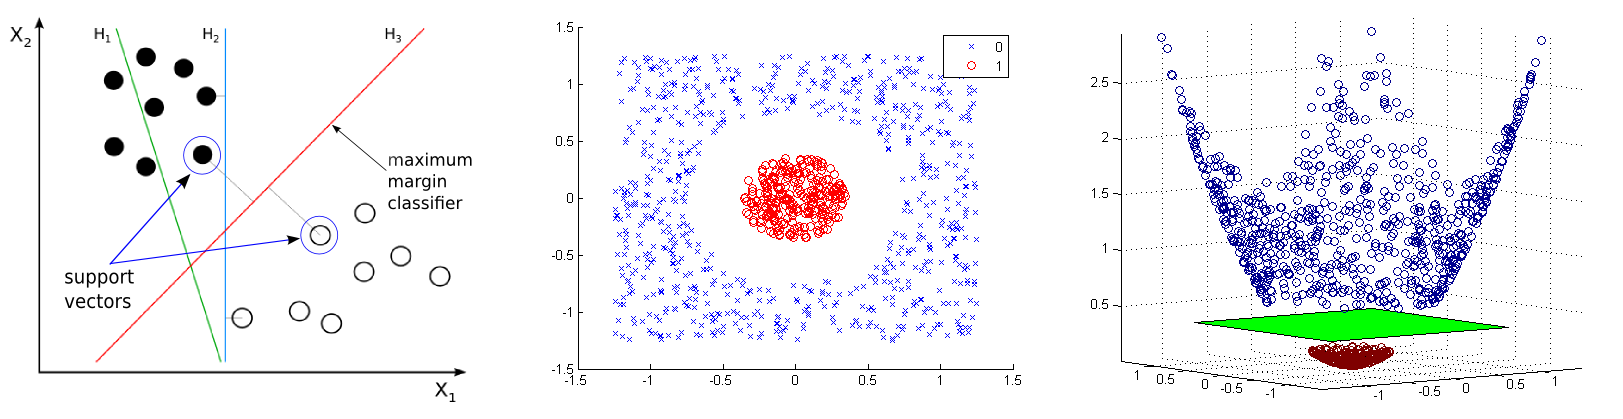

In [ ]:
from IPython.display import Image
Image(filename='/imgs/svm_diagram.png', width=1000)

In [ ]:
#X = d.values[:,:-1]
#y = d.values[:,-1]

#X = d.values[:,:-3]
#y = d.values[:,-1]

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

est = SVC()

s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print("tpr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print("tnr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.999 (+/- 0.00291)
tpr      1.000 (+/- 0.00000)
tnr      0.995 (+/- 0.00836)


- **Pros:** Effective in high-dimensional spaces and versatile due to different kernel functions that can be specified for the decision function.
- **Cons:** Requires careful tuning of parameters and selection of the kernel. Can be inefficient with large datasets.

## <span style="color:orange">student</span>:

**Objective:**

To predict passenger survival on the Titanic using a subset of features (Pclass, Sex, Age). Using the method you prefer.


**Dataset:**

The dataset is located in the practice directory and includes information about the passengers aboard the Titanic.


**Methodology:**
- Data Preparation: Load and preprocess the data to handle missing values, convert categorical variables to numerical ones, and extract the relevant features for the classification task.
- Model Training: Train the Gaussian Naive Bayes, Decision Tree, Random Forest, and Support Vector Machine models on the training data.
- Model Evaluation: Evaluate the accuracy and other performance metrics of each model using the test data.

# References

[1] Tutorial on k-fold cross validation https://machinelearningmastery.com/k-fold-cross-validation/

[2] Titanic dataset. https://www.kaggle.com/c/titanic

[3] Sensitivity and specificity: https://en.wikipedia.org/wiki/Sensitivity_and_specificity

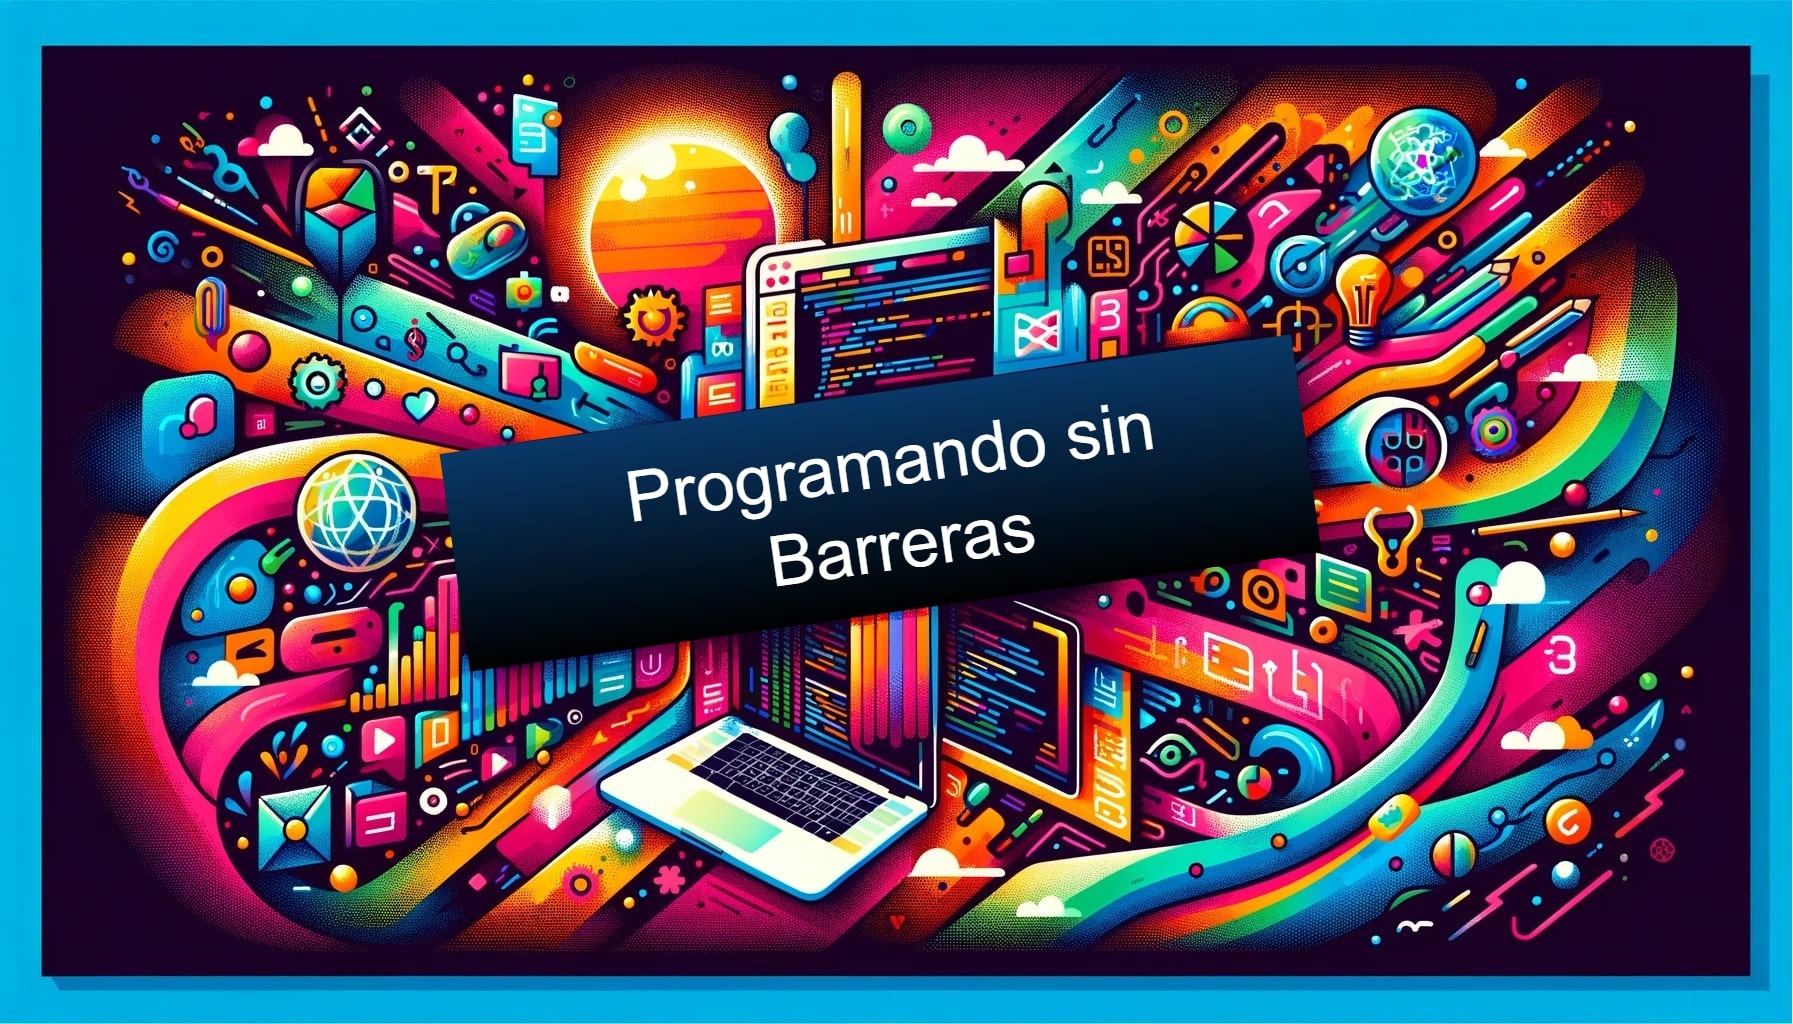